#**Machine Learning network for a commercial SG340P photovoltaic power prediction using different environmental data of Vitoria-Gasteiz, Spain. **







**Objective:** the goal of this project is to obtain an accurate model which can predict the maximum power point of a commercial SG340P PV system. 



**Project discription:** Since the PV output power depends on the weather conditiones (Temperature & Irradiations), we have collected an extensive dataset aiming to cover various operating conditions. The collecting process was simlified via the design of an automated algorithm which varies the PV output voltage from V_min to V_max each period of time. Throught this variation, the whole PV parameters (temperature, Irradiation, current, voltage, power) were recorded online via ControlDesk software. The obtained dataset was loaded in IBM db2 database; then, the following assingmets were performed in this notebook:

* **Read data from IBM db2 database.** 
* **Clean & visuolize the data.**
* **Filter the data.**
* **Extract the maximum power points.**
* **Apply statistics.**
* **Model construction**

We have published this project in ***energies*** journal. Therefore, for a detailed discription please see section 3 of the following link: https://www.mdpi.com/1996-1073/14/22/7806



# Setup

## Installing the required packages

In [ ]:
!pip install pyspark
!pip install findspark
import findspark
findspark.init()

!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa==0.3.7

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 60.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=1625103b7c5893723e4a70d1fc83b8cf4f4b93282fd57728f65cd4717e421948
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 6.0 MB 4.6 MB/s 
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp37-cp37m-linux_x86_64.whl size=1203568 sha256=6cac7a8a923f551081a42486eb154e597db74944ad5edaf19aec5927917e8a44
  Stored in directory: /root/.cache/pip/wheels/03/71/13/010faf12246f72dc76b4150e6e599d13a85b4435e06fb9e51f
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.32
    Uninstalling SQLAlchemy-1.4.32:
      Successfully uninstalled SQLAlchemy-1.4.32
     |████████████████████████████████| 1.1 MB 8.0 MB/

## Importing the Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
from scipy.signal import butter,filtfilt
from google.colab import files

# Keras / Sklearn
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Spark Session / Pipeline / Functions / and Metrics
import sys
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import LinearRegression

import ibm_db
import ibm_db_sa
import ibm_db_dbi
import sqlalchemy
from sqlalchemy import *

# 1) Connect to the db2 database

## 1) First method




In [ ]:
#Replace the placeholder values with your actual Db2 hostname, username, and password:
dsn_hostname = "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "wzw37676"        # e.g. "abc12345"
dsn_pwd = "RqVbtpgxaho1uE5S"      # e.g. "7dBZ3wWt9XN6$o0J"

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "31929"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "ssl"              #i.e. "SSL"

#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd,dsn_security)
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  wzw37676 on host:  55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud


In [ ]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)
#query statement to retrieve all rows in INSTRUCTOR table
data1 = "select * from PV_DATA1"
data2 = "select * from PV_DATA2"
data_max = "select * from PV_DATA_MAX"
#retrieve the query results into a pandas dataframe
df1 = pd.read_sql(data1, pconn)
df2 = pd.read_sql(data2, pconn)
# Joining DataFrames
df = pd.concat([df1, df2], axis=1)

# df_max = pd.read_sql(data_max, pconn)

## 2) Second method

In [ ]:
# %load_ext sql

# # Enter the connection string for your Db2 on Cloud database instance below
# # %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name?security=SSL
# %sql ibm_db_sa://wzw37676:RqVbtpgxaho1uE5S@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb?security=SSL 

# # Retrieve list of all tables in the database for db2 schema (username)
# %sql select tabschema, tabname, create_time from syscat.tables where tabschema='WZW37676' and tabname like 'PV%'



# data1= %sql select * from PV_DATA1
# data2= %sql select * from PV_DATA2
# data_max= %sql select * from PV_DATA_MAX 

# #Loading data into a Pandas DataFrame
# df1 = data1.DataFrame()
# df2 = data2.DataFrame()
# df_max = data_max.DataFrame()

# 2) Data cleaning & visualization 

In [ ]:
df

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,...,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,...,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,...,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,...,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,...,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,...,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(308579, 60)

#### a) Pandas  

In [ ]:
# # Replace NaN Values with Zeros
# df0 = df.replace(np.nan, 0)

# # Replace rows zeros by the last recording data for each graph
# df_replaced_rows=df0
# for columns in range(len(df_replaced_rows.columns)):
#   for rows in range(1,len(df_replaced_rows)):
#     if df_replaced_rows.iloc[rows,columns]== 0:
#       df_replaced_rows.iloc[rows,columns]=df_replaced_rows.iloc[rows-1,columns]
# df_replaced_rows

#### b) Pyspark

In [ ]:
# Creating a spark context class
# conf = SparkConf().setAppName('Spark_MLP').setMaster('local[*]')
# sc = SparkContext(conf=conf)
sc = SparkContext()


# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python_Spark_DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# Load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Schema of the loaded spark dataframe
# sdf.printSchema()



In [ ]:
cols = sdf.columns # list of all columns

sdf_nul = sdf.replace(float('nan'), None)
sdf_replaced_rows = sdf_nul

for col in cols:
  sdf_replaced_rows= sdf_replaced_rows.withColumn(col,last(col, True).over(Window.rowsBetween(-sys.maxsize, 0)))

sdf_replaced_rows.show(3)

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|     TIME01|     T_PV01|     G_PV01|     I_PV01|     V_PV01|     P_PV01|     TIME02|     T_PV02|     G_PV02|     I_PV02|     V_PV02|     P_PV02|     TIME03|     T_PV03|     G_PV03|     I_PV03|     V_PV03|     P_PV03|     TIME04|     T_PV04|     G_PV04|     I_PV04|     V_PV04| 

In [ ]:
# show the last 10 rows in spark dataFrame
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc

sdf_replaced_rows = sdf_replaced_rows.withColumn("column_index", monotonically_increasing_id())
sdf_replaced_rows.orderBy(desc("column_index")).drop("column_index").show(3)
sdf_replaced_rows = sdf_replaced_rows.drop('column_index') # remove the Index column

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----------+----------+-----------+-----------+-----------+-----------+---------+----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+----------+----------+-----------+
|     TIME01|     T_PV01|     G_PV01|     I_PV01|     V_PV01|     P_PV01|     TIME02|     T_PV02|     G_PV02|    I_PV02|     V_PV02|     P_PV02|     TIME03|     T_PV03|     G_PV03|     I_PV03|     V_PV03|     P_PV03|    TIME04|     T_PV04|     G_PV04|    I_PV04|     V_PV04|     P_PV04|     T

In [ ]:
#Convert PySpark Dataframe to Pandas DataFrame
df_replaced_rows = sdf_replaced_rows.toPandas()
df_replaced_rows

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,...,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,...,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,...,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,...,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,...,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,...,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,1220.543098,7.052002,88.806152,0.267354,43.185762,11.545879,1665.097284,7.686768,134.582519,0.273943,...,206.726074,2.050630,1.099678,2.255033,10852.410710,31.490479,605.712891,5.887614,1.294866,7.623673
308575,1220.543098,7.052002,88.806152,0.267354,43.185762,11.545879,1665.097284,7.686768,134.582519,0.273943,...,206.726074,2.050630,1.099678,2.255033,10852.410710,31.490479,605.712891,5.887614,1.294866,7.623673
308576,1220.543098,7.052002,88.806152,0.267354,43.185762,11.545879,1665.097284,7.686768,134.582519,0.273943,...,206.726074,2.050630,1.099678,2.255033,10852.410710,31.490479,605.712891,5.887614,1.294866,7.623673
308577,1220.543098,7.052002,88.806152,0.267354,43.185762,11.545879,1665.097284,7.686768,134.582519,0.273943,...,206.726074,2.050630,1.099678,2.255033,10852.410710,31.490479,605.712891,5.887614,1.294866,7.623673


In [ ]:
# determination of x-axis and y-axis 
col=df_replaced_rows.columns
def X_and_Y_axis(col):
  X=[]
  Y=[]
  for i in range(0,len(col),6):
    index=col[i+4] 
    X.append(index)
    index=col[i+4] 
    X.append(index)
    index=col[i]
    X.append(index)
    index=col[i] 
    X.append(index)

    index=col[i+5] 
    Y.append(index)
    index=col[i+3] 
    Y.append(index)
    index=col[i+1]
    Y.append(index)
    index=col[i+2] 
    Y.append(index)
  return X, Y



X,Y=X_and_Y_axis(col);
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


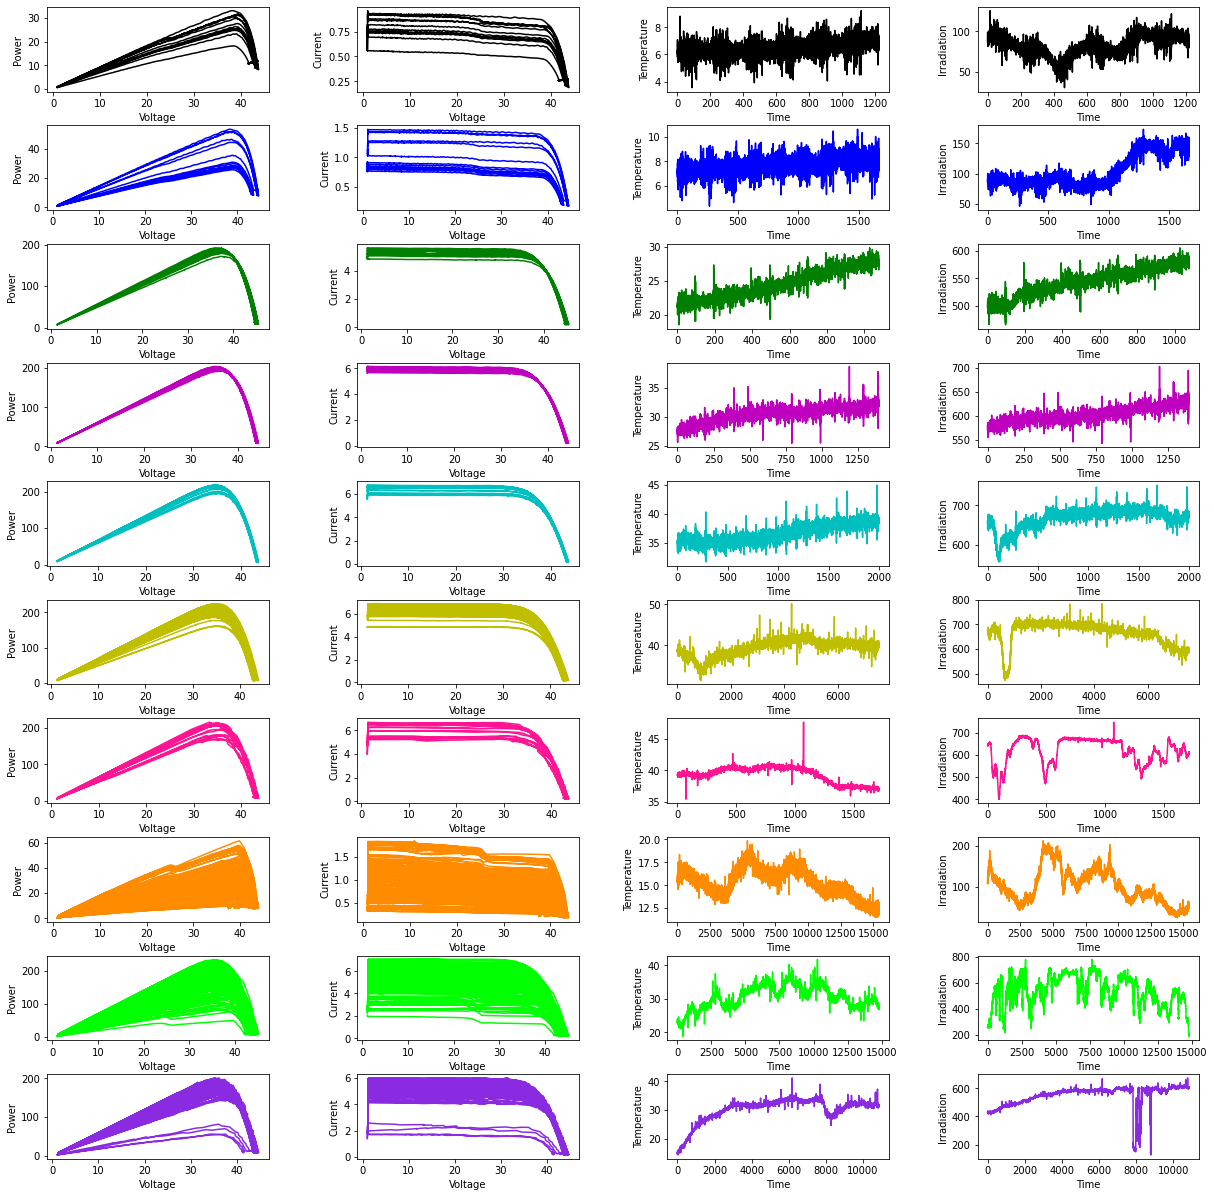

In [ ]:
colors=['k','b','g','m','c','y','deeppink','darkorange','lime','blueviolet',]                
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis
nb_rows = 10  
nb_columns = 4  
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

data_frame=df_replaced_rows


def subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig):
  itm=0
  color=0
  for i in range(nb_rows): 
    index=0 
    for j in range(nb_columns):
      plt.subplot(nb_rows, nb_columns, plt_counter)
      # plt.title('subplot: {} {} {}'.format( a, b, c))
      plt.xlabel(Xlab[index])
      plt.ylabel(Ylab[index])
      plt.plot(data_frame[X[itm]], data_frame[Y[itm]], colors[color]) #,label=k2[index]
      plt_counter = plt_counter + 1
      itm= itm + 1
      index=index+1
    color=color+1
  plt.show()

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)


## 2) Filtring the Temperature and Irradiation signals

In [ ]:


# Define the filter requirements
T = 1.0         # Sample Period
fs = 200.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


# Filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    F = filtfilt(b, a, data)
    return F


df_filtered = df_replaced_rows

col=df_filtered.columns
for i in range(0,len(col),6):
  data=df_filtered[col[i+1]]
  Filterd_temperature = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+1]]=Filterd_temperature

  data=df_filtered[col[i+2]]
  Filterd_irradiation = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+2]]=Filterd_irradiation



In [ ]:
col=df_filtered.columns
X,Y= X_and_Y_axis(col)
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


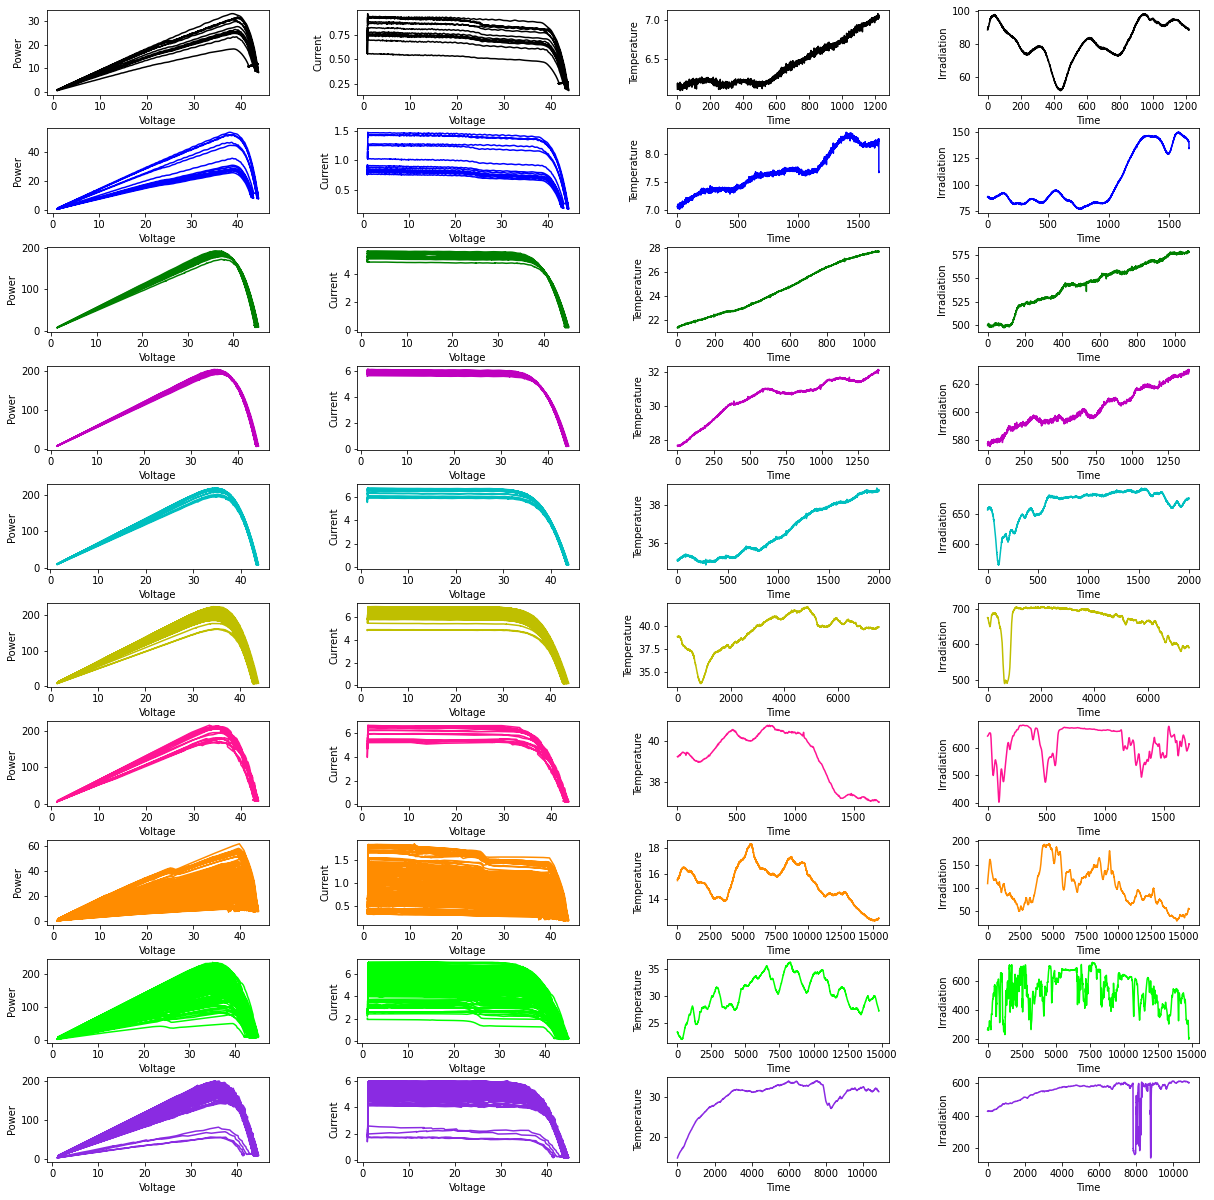

In [ ]:
data_frame=df_filtered
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)

# 3) Maximum power points

To claculate the maximum power pint for each curve, first we need to plot the power versus the time

In [ ]:

# determination of x-axis and y-axis 
col=df.columns
Time=[]   
Temperature=[]
Irradiation=[]
Current=[]
Voltage=[]
Power=[]

Time_index=[]
Temperature_index=[]
Irradiation_index=[]
Current_index=[]
Voltage_index=[]
Power_index=[]

for i in range(0,len(col),6):
  index=col[i] 
  Time.append(index)
  Time_index.append(i)
  index=col[i+1] 
  Temperature.append(index)
  Temperature_index.append(i+1)
  index=col[i+2]
  Irradiation.append(index)
  Irradiation_index.append(i+2)
  index=col[i+3] 
  Current.append(index)
  Current_index.append(i+3)
  index=col[i+4] 
  Voltage.append(index)
  Voltage_index.append(i+4)
  index=col[i+5] 
  Power.append(index)
  Power_index.append(i+5)


# convert list to array
Time=np.array(Time)
Temperature=np.array(Temperature)
Irradiation=np.array(Irradiation)
Current=np.array(Current)
Voltage=np.array(Voltage)
Power=np.array(Power)

print(Time_index,'\n', Temperature_index,'\n',Irradiation_index,'\n',Current_index,'\n',Voltage_index,'\n',Power_index)
print(Time,'\n', Temperature,'\n',Irradiation,'\n',Current,'\n',Voltage,'\n',Power)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54] 
 [1, 7, 13, 19, 25, 31, 37, 43, 49, 55] 
 [2, 8, 14, 20, 26, 32, 38, 44, 50, 56] 
 [3, 9, 15, 21, 27, 33, 39, 45, 51, 57] 
 [4, 10, 16, 22, 28, 34, 40, 46, 52, 58] 
 [5, 11, 17, 23, 29, 35, 41, 47, 53, 59]
['TIME01' 'TIME02' 'TIME03' 'TIME04' 'TIME05' 'TIME06' 'TIME07' 'TIME08'
 'TIME09' 'TIME10'] 
 ['T_PV01' 'T_PV02' 'T_PV03' 'T_PV04' 'T_PV05' 'T_PV06' 'T_PV07' 'T_PV08'
 'T_PV09' 'T_PV10'] 
 ['G_PV01' 'G_PV02' 'G_PV03' 'G_PV04' 'G_PV05' 'G_PV06' 'G_PV07' 'G_PV08'
 'G_PV09' 'G_PV10'] 
 ['I_PV01' 'I_PV02' 'I_PV03' 'I_PV04' 'I_PV05' 'I_PV06' 'I_PV07' 'I_PV08'
 'I_PV09' 'I_PV10'] 
 ['V_PV01' 'V_PV02' 'V_PV03' 'V_PV04' 'V_PV05' 'V_PV06' 'V_PV07' 'V_PV08'
 'V_PV09' 'V_PV10'] 
 ['P_PV01' 'P_PV02' 'P_PV03' 'P_PV04' 'P_PV05' 'P_PV06' 'P_PV07' 'P_PV08'
 'P_PV09' 'P_PV10']


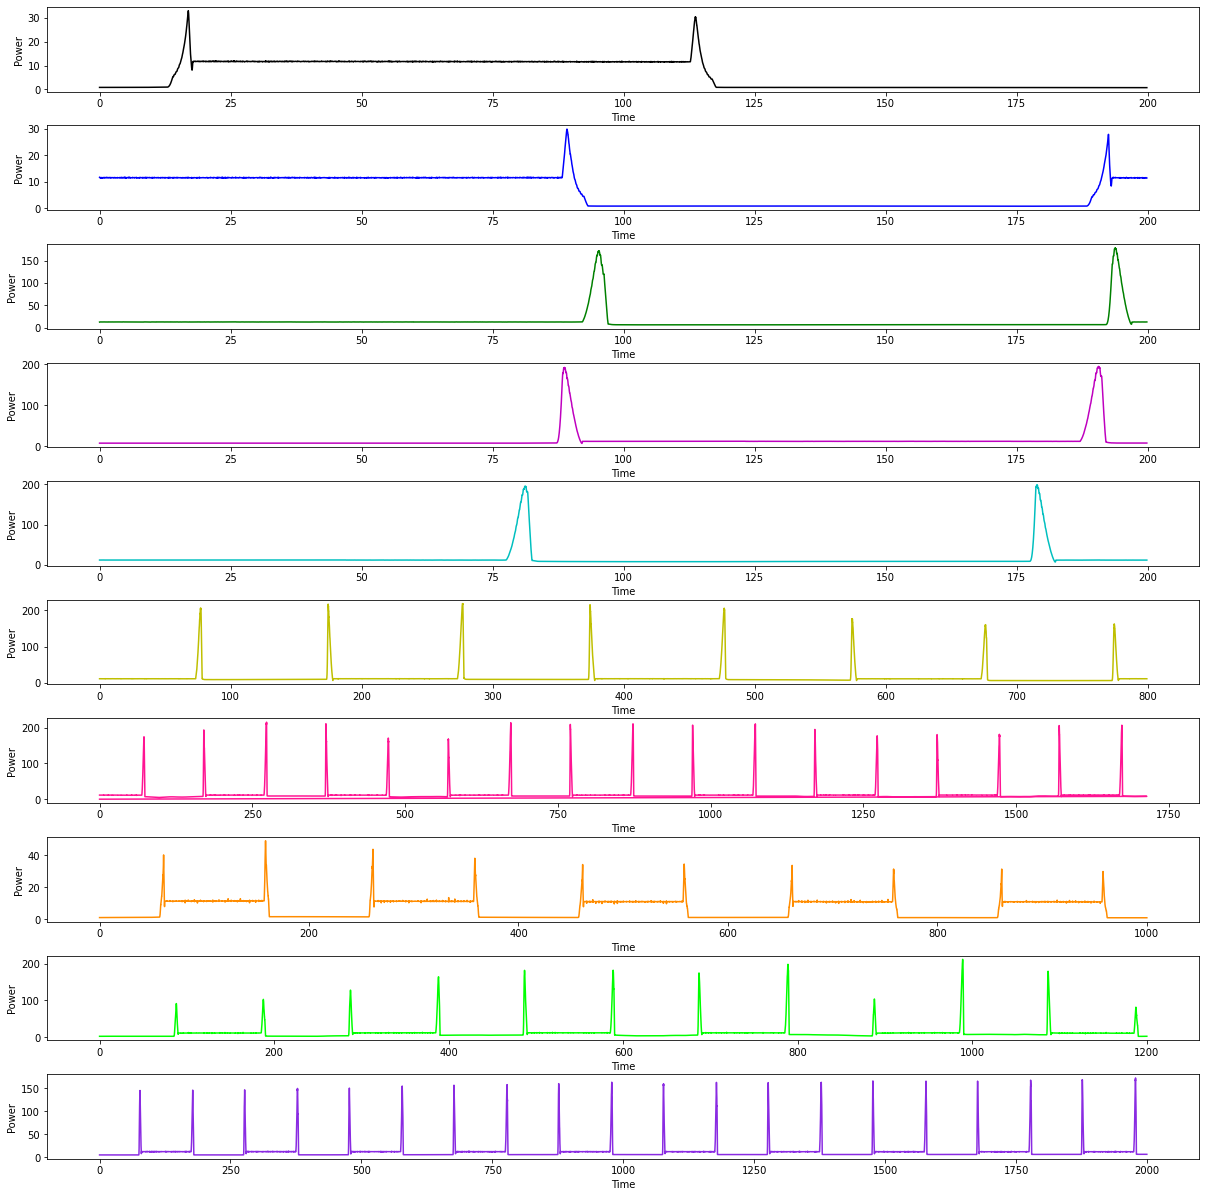

In [ ]:
nb_rows = 10  
nb_columns = 1 
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Replace NaN Values with Zeros
df0 = df.replace(np.nan, 0)

# Plot the first 20 000 rows
df_limit=df0[0:20000]

itm=0
for i in range(len(Time)): 
  plt.subplot(nb_rows, nb_columns, plt_counter)
  # plt.title('subplot: {} {} {}'.format( a, b, c))
  plt.xlabel('Time')
  plt.ylabel('Power')
  plt.plot(df_limit[Time[itm]], df_limit[Power[itm]], colors[itm]) #,label=k2[index]
  plt_counter = plt_counter + 1
  itm= itm + 1
plt.show()

We have ploted the Power Vs Time for the first 20 000 row in order to dtermine the periods used for recording. So according to the graph above, we can calculate the maximum power using the followin information:
- For the first 5 graphs we can calculate the maximum power for each 10.000 row.
- For the 6th graph we can calculate the maximum power for each 2.500 row.
- For the 7th and 10th graph we can calculate the maximum power for each 1000 row.
- For the 8th graph we can calculate the maximum power for each 2000 row.
- For the 9th graph we can calculate the maximum power for each 10.000/6 row.


In [ ]:
# Extracting the maximum power points
PMAX=[]
VMAX=[]
IMAX=[]
GMAX=[]
TMAX=[]
MAX_index=[]

cursor=0
previous_max_value=0
for i in range(len(Power)):
  if cursor<5:
    step=10000
  if cursor==5:
    step=2500
  if cursor==6 or cursor==9:
    step=1000
  if cursor==7:
    step==2000
  if cursor==8:
    step=10000//6
  for j in range(0,len(df_filtered[Power[i]]),step):
    k=j
    max_value=np.max(df_filtered.iloc[k:k+step,Power_index[cursor]])
    if max_value != previous_max_value:
      PMAX.append(max_value)
      max_index = df_filtered[df_filtered[Power[i]]==max_value].index.values.astype(int)[0]
      MAX_index.append(max_index)
      IMAX.append(df_filtered.iloc[max_index,Current_index[cursor]])
      VMAX.append(df_filtered.iloc[max_index,Voltage_index[cursor]])
      GMAX.append(df_filtered.iloc[max_index,Irradiation_index[cursor]])
      TMAX.append(df_filtered.iloc[max_index,Temperature_index[cursor]])
    previous_max_value=max_value
    k1=j
  cursor=cursor+1  
print(len(PMAX),'\n')

744 



In [ ]:
# Convert the lists of the maximum to Pandas Dataframe

# df_MAX = pd.DataFrame(list(zip(MAX_index, PMAX, VMAX, IMAX, GMAX, TMAX)), columns = ['MAX_index', 'PMAX', 'VMAX', 'IMAX', 'GMAX', 'TMAX'])
# df_MAX.head()
# Or we can use dictionary
dictionary = {'IMAX': IMAX, 'VMAX': VMAX, 'PMAX': PMAX,  'GMAX': GMAX, 'TMAX': TMAX} #'MAX_index': MAX_index,
df_max = pd.DataFrame(dictionary)
df_max.head()

,IMAX,VMAX,PMAX,GMAX,TMAX
0,0.868494,38.084686,33.076332,94.742025,6.102379
1,0.794872,38.304861,30.447451,87.917330,6.232654
2,0.667795,38.003550,25.378564,75.654462,6.262755
3,0.678806,38.840862,26.365400,78.384624,6.159151
4,0.471769,38.448103,18.138638,54.539170,6.201896


In [ ]:
# # In case the database is connected via the method 2, then the following error will apear when plotting the 3d graph: 
# # unsupported operand type(s) for *: 'float' and 'decimal.Decimal'. To solve this error, the following code can be used:
# for col in df_max.columns:
#   df_max[col]=np.array(df_max[col], dtype=float)

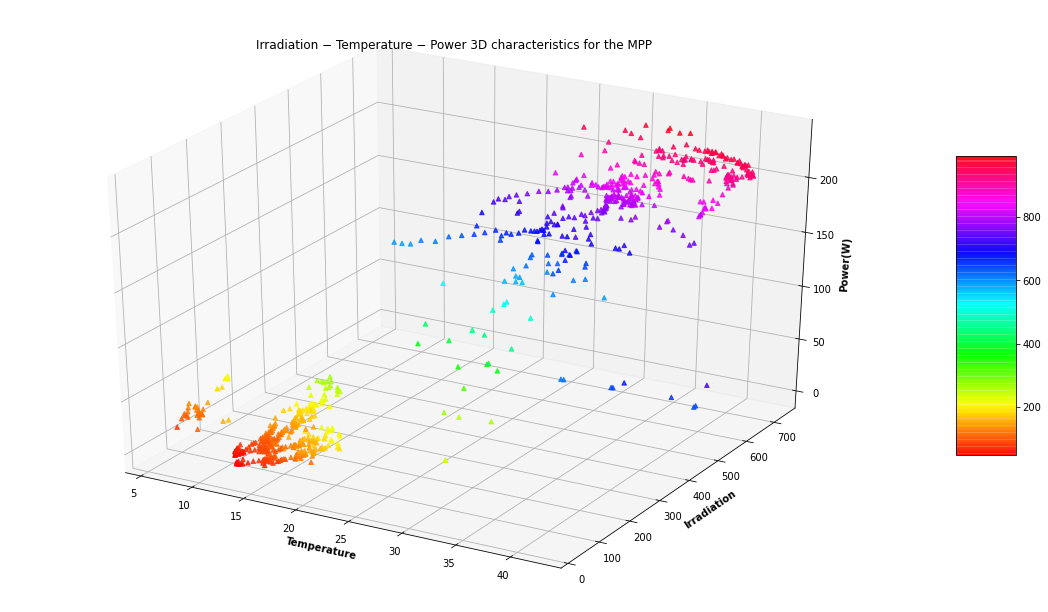

In [ ]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df_max['TMAX']
y=df_max['GMAX']
z=df_max['PMAX']

sctt = ax.scatter3D(x, y, z,
                    alpha = .8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Irradiation − Temperature − Power 3D characteristics for the MPP")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
plt.show()

# 4) Statistical analysis

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

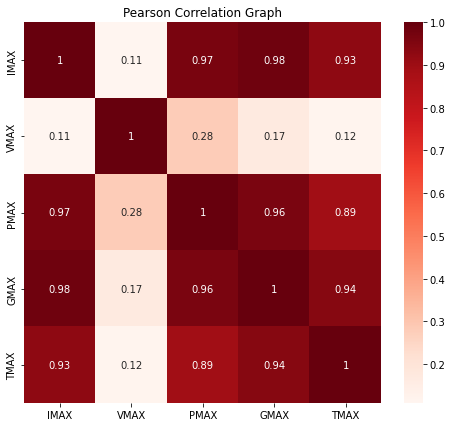

In [ ]:
plt.figure(figsize=(8,7))
corr_pearson = df_max.corr(method="pearson")
sns.heatmap(corr_pearson, annot=True, cmap=plt.cm.Reds)
plt.title("Pearson Correlation Graph")
plt.show()

### b) *Spearman* correlation

**Comparison of Pearson and Spearman coefficients**
* The fundamental difference between the two correlation coefficients is that the Pearson coefficient works with a linear relationship between the two variables whereas the Spearman Coefficient works with monotonic relationships as well. 
* * A monotonic relationship is a relationship that does one of the following:  1. As the value of one variable increases, so does the value of the other variable, OR; 2. As the value of one variable increases, the other variable value decreases.

* Now, if we feel that a scatterplot is visually indicating a “might be monotonic, might be linear” relationship, our best bet would be to apply Spearman and not Pearson. No harm would be done by switching to Spearman even if the data turned out to be perfectly linear. But, if it’s not exactly linear and we use Pearson's coefficient then we’ll miss out on the information that Spearman could capture.

**NOTE: If a scatterplot indicates a relationship that cannot be expressed by a linear or monotonic function, then both of these coefficients must not be used to determine the strength of the relationship between the variables**

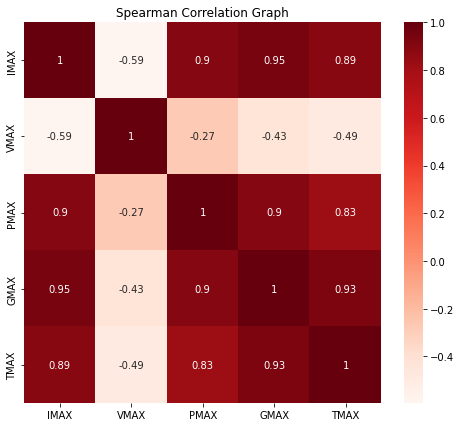

In [ ]:
plt.figure(figsize=(8,7))
corr_spearman = df_max.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, cmap=plt.cm.Reds)
plt.title("Spearman Correlation Graph")
plt.show()

In [ ]:
corr_spearman

,IMAX,VMAX,PMAX,GMAX,TMAX
IMAX,1.000000,-0.594055,0.900611,0.945893,0.888289
VMAX,-0.594055,1.000000,-0.271671,-0.432807,-0.490395
PMAX,0.900611,-0.271671,1.000000,0.904337,0.829486
GMAX,0.945893,-0.432807,0.904337,1.000000,0.928262
TMAX,0.888289,-0.490395,0.829486,0.928262,1.000000


In [ ]:
#Correlation with output variables IMAX or VMAX

target1= corr_spearman[["VMAX"]]
# target1=target1[target1>0.5]
target1

,VMAX
IMAX,-0.594055
VMAX,1.000000
PMAX,-0.271671
GMAX,-0.432807
TMAX,-0.490395


In [ ]:
target2= corr_spearman[["IMAX"]]
target2

,IMAX
IMAX,1.000000
VMAX,-0.594055
PMAX,0.900611
GMAX,0.945893
TMAX,0.888289


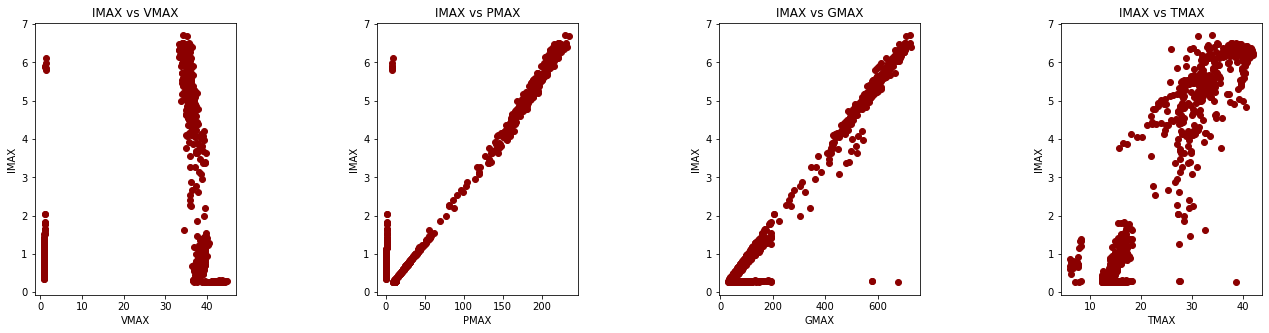

In [ ]:
def plot_data_corr(df,title,color="darkred"):    
    # r = display_correlation(df)
    fig, ax = plt.subplots(nrows=1, ncols=len(df.columns)-1,figsize=(22,5))
    for i in range(1,len(df.columns)):
        ax[i-1].scatter(df.values[:,i], df["IMAX"], color=color)
        ax[i-1].title.set_text(title[i-1])
        ax[i-1].set(xlabel=df.columns[i],ylabel=df.columns[0])
    fig.subplots_adjust(wspace=.7)    
    plt.show()

plot_data_corr(df_max,["IMAX vs VMAX","IMAX vs PMAX","IMAX vs GMAX","IMAX vs TMAX"])

In [ ]:
# loading data into spark dataFrame
sdf_max = spark.createDataFrame(df_max)
sdf_max.show(5)


+-----------+-----------+-----------+------------------+-----------------+
|       IMAX|       VMAX|       PMAX|              GMAX|             TMAX|
+-----------+-----------+-----------+------------------+-----------------+
|0.868494273|38.08468646|33.07633206| 94.74202509856494|6.102379133658507|
|0.794871716|38.30486147|30.44745098| 87.91733043126995|6.232654305998735|
|0.667794556|38.00355043|25.37856409| 75.65446192018234|6.262755346460471|
| 0.67880574|38.84086158| 26.3653998| 78.38462406808368|6.159151151460771|
|0.471769384|38.44810318|18.13863796|54.539169606932056|6.201895524493021|
+-----------+-----------+-----------+------------------+-----------------+
only showing top 5 rows



In [ ]:
# Drop unnecessary columns (selecting highly correlated features)
sdf_max_dataset=sdf_max.drop('TMAX', 'VMAX')
sdf_max_dataset.show(5)

+-----------+-----------+------------------+
|       IMAX|       PMAX|              GMAX|
+-----------+-----------+------------------+
|0.868494273|33.07633206| 94.74202509856494|
|0.794871716|30.44745098| 87.91733043126995|
|0.667794556|25.37856409| 75.65446192018234|
| 0.67880574| 26.3653998| 78.38462406808368|
|0.471769384|18.13863796|54.539169606932056|
+-----------+-----------+------------------+
only showing top 5 rows



In [ ]:
#Converting data frame columns into feature vectors
required_features=['PMAX', 'GMAX']

assembler = VectorAssembler(
    inputCols=required_features,
    outputCol="Features")

transformed_data = assembler.transform(sdf_max_dataset).select('Features','IMAX')
transformed_data.show(5)

+--------------------+-----------+
|            Features|       IMAX|
+--------------------+-----------+
|[33.07633206,94.7...|0.868494273|
|[30.44745098,87.9...|0.794871716|
|[25.37856409,75.6...|0.667794556|
|[26.3653998,78.38...| 0.67880574|
|[18.13863796,54.5...|0.471769384|
+--------------------+-----------+
only showing top 5 rows




##2) Normalization & Standardization


* Standardization and normalization are two ways to rescale data.
* Normalization is used when the data doesn't have Gaussian (Normal) distribution whereas Standardization is used on data having Gaussian distribution.
* Normalization scales in a range of [0,1] or [-1,1]. Standardization is not bounded by range.




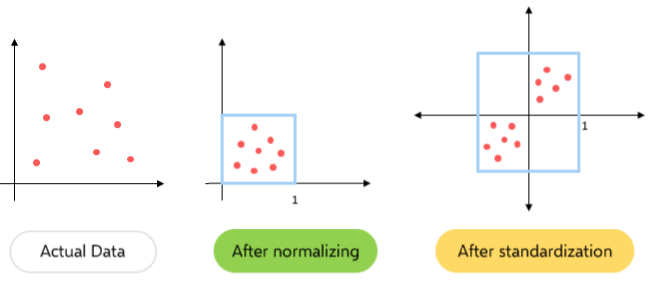

### a) Normalization
* Normalization rescales a dataset so that each value falls between 0 and 1. It uses the following formula to do so:

xnew = (xi – xmin) / (xmax – xmin)

* Normalizing the data generally speeds up learning and leads to faster convergence.

* If x is the vector of covariates of length n, and say that the normalized vector is y=x/z then the three options denote what to use for z:

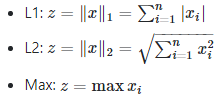

In [ ]:
normalizer1 = Normalizer(inputCol="Features", outputCol="Features_normalized", p=1.0)
normalized_data1 = normalizer1.transform(transformed_data)
print("Normalized using L^1 norm")
normalized_data1.show(5, truncate=False)

Normalized using L^1 norm
+--------------------------------+-----------+----------------------------------------+
|Features                        |IMAX       |Features_normalized                     |
+--------------------------------+-----------+----------------------------------------+
|[33.07633206,94.74202509856494] |0.868494273|[0.2587760693791987,0.7412239306208013] |
|[30.44745098,87.91733043126995] |0.794871716|[0.2572340405395366,0.7427659594604634] |
|[25.37856409,75.65446192018234] |0.667794556|[0.25119077486051233,0.7488092251394877]|
|[26.3653998,78.38462406808368]  |0.67880574 |[0.2516982700949368,0.7483017299050633] |
|[18.13863796,54.539169606932056]|0.471769384|[0.24957602007043708,0.7504239799295629]|
+--------------------------------+-----------+----------------------------------------+
only showing top 5 rows



In [ ]:
normalizer2 = Normalizer(inputCol="Features", outputCol="Features_normalized", p=2.0)
normalized_data2 = normalizer2.transform(transformed_data)
print("Normalized using L^2 norm")
normalized_data2.show(5, truncate=False)

Normalized using L^2 norm
+--------------------------------+-----------+----------------------------------------+
|Features                        |IMAX       |Features_normalized                     |
+--------------------------------+-----------+----------------------------------------+
|[33.07633206,94.74202509856494] |0.868494273|[0.32961013573496384,0.9441171317271914]|
|[30.44745098,87.91733043126995] |0.794871716|[0.3272500083909345,0.9449377926658099] |
|[25.37856409,75.65446192018234] |0.667794556|[0.3180363803176979,0.9480785098262784] |
|[26.3653998,78.38462406808368]  |0.67880574 |[0.31880788563407125,0.9478193562370062]|
|[18.13863796,54.539169606932056]|0.471769384|[0.3155843553781329,0.9488975258902135] |
+--------------------------------+-----------+----------------------------------------+
only showing top 5 rows



In [ ]:
Scaler = MinMaxScaler(inputCol="Features", outputCol="Features_normalized")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = Scaler.fit(transformed_data)

# rescale each feature to range [min, max].
normalized_data3 = scalerModel.transform(transformed_data)

print("Features scaled to range: [%f, %f]" % (Scaler.getMin(), Scaler.getMax()))
normalized_data3.show(5, truncate=False)
# scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------------------+-----------+-----------------------------------------+
|Features                        |IMAX       |Features_normalized                      |
+--------------------------------+-----------+-----------------------------------------+
|[33.07633206,94.74202509856494] |0.868494273|[0.13979123966746484,0.09427992965262519]|
|[30.44745098,87.91733043126995] |0.794871716|[0.1285774461513959,0.08448696204823046] |
|[25.37856409,75.65446192018234] |0.667794556|[0.10695552822851716,0.06689058888863363]|
|[26.3653998,78.38462406808368]  |0.67880574 |[0.11116498904072829,0.0708081838540564] |
|[18.13863796,54.539169606932056]|0.471769384|[0.0760727936266872,0.036591596235978546]|
+--------------------------------+-----------+-----------------------------------------+
only showing top 5 rows



**Note:** For regression problems we don't normally normalize the outputs if it is a one demention. However this is not the case for the multiregression values. 

### b) Standardization

* Standardization rescales a dataset to have a mean of 0 and a standard deviation of 1. It uses the following formula to do so:

xnew = (xi – x) / s

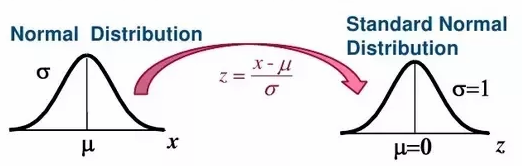

In [ ]:
standard_scaler = StandardScaler(inputCol="Features", outputCol="Features_standardized")
stand = standard_scaler.fit(transformed_data)
standardized_data = stand.transform(transformed_data)
standardized_data.show(5, truncate=False)

+--------------------------------+-----------+-----------------------------------------+
|Features                        |IMAX       |Features_standardized                    |
+--------------------------------+-----------+-----------------------------------------+
|[33.07633206,94.74202509856494] |0.868494273|[0.37916724600970947,0.3785162184168375] |
|[30.44745098,87.91733043126995] |0.794871716|[0.34903132896236344,0.3512499908412019] |
|[25.37856409,75.65446192018234] |0.667794556|[0.29092464775812293,0.302257005828154]  |
|[26.3653998,78.38462406808368]  |0.67880574 |[0.30223714086485515,0.31316463262643385]|
|[18.13863796,54.539169606932056]|0.471769384|[0.20793047394688585,0.21789654816575307]|
+--------------------------------+-----------+-----------------------------------------+
only showing top 5 rows



In [ ]:
# select only features and labels for final dataFrame
normalized_data1=normalized_data1.drop('features')

# Split
training_data, test_data = normalized_data1.randomSplit([0.8, 0.2])

print('trianing data:', (training_data.count(), len(training_data.columns)))
print('test data: ', (test_data.count(), len(test_data.columns)))

# Shuffle dataset: 
training_data = training_data.orderBy(rand())
print('shuffled data:')
training_data.show(5)
#shuffle helps the training to converge fast. it prevents any bias during the training. it prevents the model from learning the order of the training.

trianing data: (590, 2)
test data:  (154, 2)
shuffled data:
+-----------+--------------------+
|       IMAX| Features_normalized|
+-----------+--------------------+
|1.260419054|[0.20387598091901...|
|4.775750522|[0.25521684441429...|
|6.062644672|[0.23874269490024...|
|6.391412762|[0.24123355199637...|
|0.813628133|[0.25189897691953...|
+-----------+--------------------+
only showing top 5 rows



# 5) Model construction

### 1) Prediction using linear regression


In [ ]:
LR = LinearRegression(featuresCol="Features_normalized", labelCol="IMAX")
model1 = LR.fit(training_data)

# Unlabelled data prediction: To predict the outputs of unlabeled data, we will predict for example the labels of the test-set
Predictions_test = model1.transform(test_data)
Predictions_test.drop("Features_normalized").show(5)

+-----------+------------------+
|       IMAX|        prediction|
+-----------+------------------+
| 0.26432481| 2.555912634147589|
|0.273121139|1.5601807153944467|
| 0.27394315|1.4611375268144577|
|0.276509111|1.3604007198651376|
|0.277844937|1.1429722416095611|
+-----------+------------------+
only showing top 5 rows



In [ ]:
# Performance evaluation
evaluation_summary = model1.evaluate(test_data)
print('MAE: ', evaluation_summary.meanAbsoluteError)
print('RMSE: ', evaluation_summary.rootMeanSquaredError)
print('r2: ', evaluation_summary.r2)


MAE:  1.9537728724539845
RMSE:  2.235286138492077
r2:  0.1399320042294827


### 2) Prediction using deep NN

Multi-layer Perceptron Regressor **MLPRegressor**



#### A) Model fitting

In [ ]:
data_Frame=sdf_max_dataset.toPandas()
data_Frame.head()

,IMAX,PMAX,GMAX
0,0.868494,33.076332,94.742025
1,0.794872,30.447451,87.917330
2,0.667795,25.378564,75.654462
3,0.678806,26.365400,78.384624
4,0.471769,18.138638,54.539170


In [ ]:
from sklearn.preprocessing import StandardScaler


x = data_Frame.drop('IMAX', axis=1)
y = data_Frame['IMAX']

trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2)



sc1=StandardScaler()
scaler = sc1.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

mlp_reg = MLPRegressor(hidden_layer_sizes=(3,3,3),
                       max_iter = 1000,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(trainX_scaled, trainY)


y_pred = mlp_reg.predict(testX_scaled)
df_temp = pd.DataFrame({'IMAX': testY, 'Predicted': y_pred})
df_temp.head()

,IMAX,Predicted
195,0.940787,0.743743
453,0.281001,0.743743
711,5.593224,5.448733
414,0.591090,0.743743
262,1.403591,1.415077


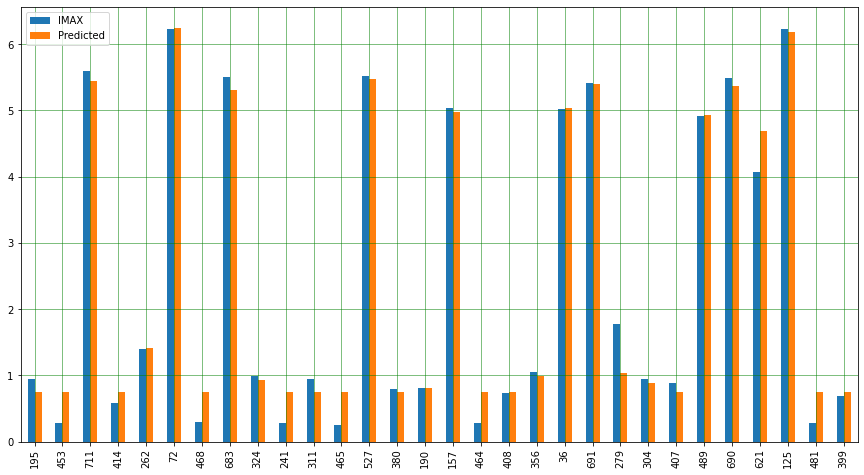

In [ ]:
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

#### B) Model Evaluation
*   R²
*   Mean Absolute Error (MAE)
*   Mean Squared Error (MSE)
*   Root Mean Squared Error (RMSE)
*   Mean Absolute Percentage Error (MAPE)

In [ ]:
print('R²: ' + str(mlp_reg.score(trainX_scaled, trainY)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, y_pred)))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(testY, y_pred))

R²: 0.9733246594163815
Mean Absolute Error: 0.2110823757665152
Mean Squared Error: 0.1898658951452313
Root Mean Squared Error: 0.4357360383824493
Mean Absolute Percentage Error: 0.4442429796146582


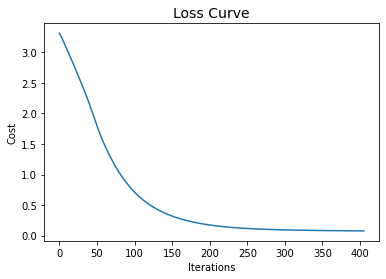

In [ ]:
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

#### C) Hyper Parameter Tuning

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(3,3,3), (4,4,4), (5,5,5), (6,6,6)],
    'max_iter': [50, 1000],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(mlp_reg, param_grid, verbose=2, n_jobs= -1, cv=5)
grid.fit(trainX_scaled, trainY)
print(grid.best_params_) 

grid_predictions = grid.predict(testX_scaled) 
df_temp2 = pd.DataFrame({'IMAX': testY, 'Predicted': grid_predictions})
df_temp2.head()

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (6, 6, 6), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}


,IMAX,Predicted
195,0.940787,0.642722
453,0.281001,0.541771
711,5.593224,5.454461
414,0.591090,0.616643
262,1.403591,1.432121


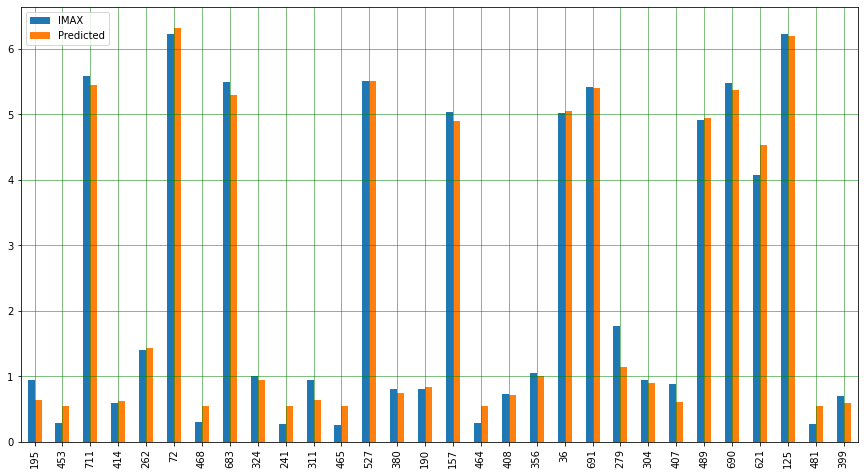

In [ ]:
df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('R²: ' + str(mlp_reg.score(trainX_scaled, trainY)))
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, grid_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, grid_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, grid_predictions)))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(testY, grid_predictions))

R²: 0.9733246594163815
Mean Absolute Error: 0.18865521560727128
Mean Squared Error: 0.14157160713283554
Root Mean Squared Error: 0.37626002595656577
Mean Absolute Percentage Error: 0.37380623635858234
